In [1]:
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math

2022-10-20 15:05:20.404305: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cvmfs/sft.cern.ch/lcg/releases/MCGenerators/thepeg/2.2.1-8d929/x86_64-centos7-gcc8-opt/lib/ThePEG:/cvmfs/sft.cern.ch/lcg/releases/MCGenerators/herwig++/7.2.1-f3599/x86_64-centos7-gcc8-opt/lib/Herwig:/cvmfs/sft.cern.ch/lcg/views/LCG_101/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/torch/lib:/cvmfs/sft.cern.ch/lcg/views/LCG_101/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/tensorflow:/cvmfs/sft.cern.ch/lcg/views/LCG_101/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/tensorflow/contrib/tensor_forest:/cvmfs/sft.cern.ch/lcg/views/LCG_101/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/tensorflow/python/framework:/cvmfs/sft.cern.ch/lcg/releases/java/8u222-884d8/x86_64-centos7-gcc8-opt/jre/lib/amd64:/cvmfs/sft.cern.ch/lcg/view

In [2]:
train_df = pd.read_csv('train_1Dy.csv',nrows=100000)
test_df = pd.read_csv('test_1Dy.csv',nrows=5000)

In [3]:
X_train = train_df.drop(columns=['y-midplane','cotBeta']).values
X_test = test_df.drop(columns=['y-midplane','cotBeta']).values

y_train = train_df['y-midplane'].values
y_test = test_df['y-midplane'].values

In [4]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler.fit_transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

In [5]:
model = Sequential()
model.add(Dense(32, input_shape=(13,), activation='relu')) # Add an input shape! (features,)
model.add(Dense(2, activation='linear'))
model.summary() 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                448       
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 66        
Total params: 514
Trainable params: 514
Non-trainable params: 0
_________________________________________________________________


2022-10-20 15:05:24.178282: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cvmfs/sft.cern.ch/lcg/releases/MCGenerators/thepeg/2.2.1-8d929/x86_64-centos7-gcc8-opt/lib/ThePEG:/cvmfs/sft.cern.ch/lcg/releases/MCGenerators/herwig++/7.2.1-f3599/x86_64-centos7-gcc8-opt/lib/Herwig:/cvmfs/sft.cern.ch/lcg/views/LCG_101/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/torch/lib:/cvmfs/sft.cern.ch/lcg/views/LCG_101/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/tensorflow:/cvmfs/sft.cern.ch/lcg/views/LCG_101/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/tensorflow/contrib/tensor_forest:/cvmfs/sft.cern.ch/lcg/views/LCG_101/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/tensorflow/python/framework:/cvmfs/sft.cern.ch/lcg/releases/java/8u222-884d8/x86_64-centos7-gcc8-opt/jre/lib/amd64:/cvmfs/sft.cern.ch/lcg/views/LCG_101/

In [6]:
def custom_loss(y, p):
    
    maxval = 1e6
    minval = 1e-9
    pi = 3.14159265359
    
    mu = tf.gather(params=p, indices=[0], axis=1)
    sigma = tf.clip_by_value(tf.gather(params=p, indices=[1], axis=1),minval,maxval)
        
    term = tf.clip_by_value(1.0/tf.math.sqrt(2*pi)/sigma*tf.math.exp(-1*(y-mu)*(y-mu)/(2*sigma*sigma)),minval,maxval)
    NLL = tf.clip_by_value(-1*tf.math.log(term),minval,maxval)
    
    return tf.keras.backend.sum(NLL,axis=1)

In [7]:
model.compile(optimizer='Adam', 
              loss=custom_loss)

In [8]:
es = EarlyStopping(patience=5)

history = model.fit(X_train,
                    y_train,
                    callbacks=[es],
                    epochs=80, 
                    batch_size=64,
                    validation_split=0.2,
                    shuffle=True,
                    verbose=1)

2022-10-20 15:05:24.319578: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-10-20 15:05:24.320649: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2894560000 Hz


Epoch 1/80
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
1250/1250 [==============================] - 2s 1ms/step - loss: 6.9174 - val_loss: 3.1810
Epoch 2/80
1250/1250 [==============================] - 1s 913us/step - loss: 2.9315 - val_loss: 2.7174
Epoch 3/80
1250/1250 [==============================] - 1s 890us/step - loss: 2.5369 - val_loss: 2.4017
Epoch 4/80
1250/1250 [==============================] - 1s 878us/step - loss: 2.3016 - val_loss: 2.2480
Epoch 5/80
1250/1250 [==============================] - 1s 859us/step - loss: 2.1871 - val_loss: 2.1614
Epoch 6/80
1250/1250 [==============================] - 1s 858us/step - loss: 2.1208 - val_loss: 2.1088
Epoch 7/80
1250/1250 [==============================] - 1s 858us/step - loss: 2.0802 - val_loss: 2.0784
Epoch 8/80
1250/1250 [==============================] - 1s 863us/step - loss: 2.0516 - val_loss: 2.0585
Epoch 9/80
1250/1250 [==========

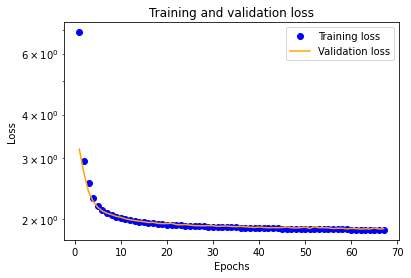

In [9]:
history_dict = history.history
loss_values = history_dict['loss'] 
val_loss_values = history_dict['val_loss'] 
epochs = range(1, len(loss_values) + 1) 
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('Log')
plt.legend()
#plt.savefig('/home/jieun201/fullprecision400e_yprofile/loss.png')

In [10]:
#model.save('models_1Dy/gausstest.keras')

In [11]:
p_test = model.predict(X_test)
df = pd.DataFrame(p_test,columns=['mu','sigma'])
df['ytrue'] = y_test
df.to_csv("test_1DyGaus.csv",header=False,index=False)

In [12]:
residuals = y_test - p_test[:,0]

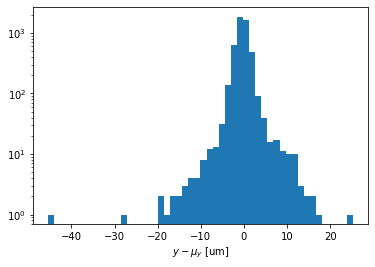

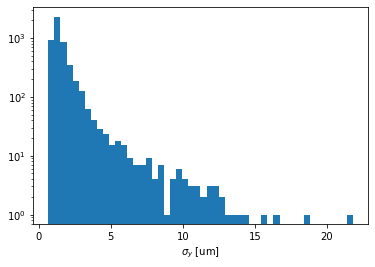

In [13]:
plt.hist(residuals,bins=50)
plt.yscale('Log')
plt.xlabel(r'$y-\mu_y$ [um]')
plt.show()

plt.hist(p_test[:,1],bins=50);
plt.yscale('Log')
plt.xlabel(r'$\sigma_y$ [um]')
plt.show()

Text(0, 0.5, 'Predicted $y$ [um]')

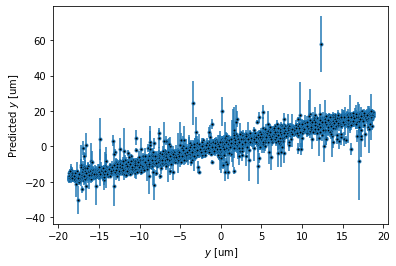

In [14]:
plt.errorbar(x=y_test,y=p_test[:,0],yerr=p_test[:,1],linestyle='',marker='.',markerfacecolor='black')
plt.xlabel(r'$y$ [um]')
plt.ylabel(r'Predicted $y$ [um]')

Text(0, 0.5, '$\\sigma_y$ [um]')

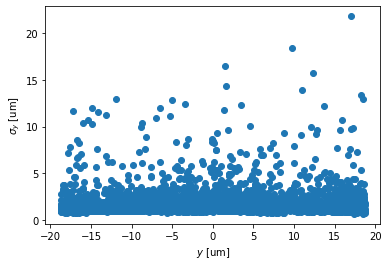

In [15]:
plt.scatter(y_test,p_test[:,1])
plt.xlabel(r'$y$ [um]')
plt.ylabel(r'$\sigma_y$ [um]')

In [16]:
pulls = residuals/p_test[:,1]

Text(0.5, 0, 'pull')

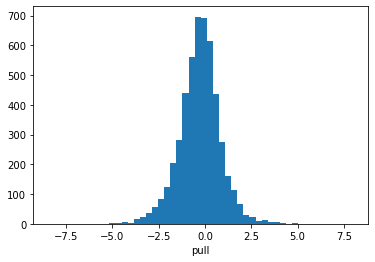

In [17]:
plt.hist(pulls,bins=50);
plt.xlabel('pull')

In [18]:
print(np.mean(pulls),np.std(pulls))

-0.27360927263626433 1.1446227845483135
